In [23]:
import cv2
import numpy as np
from PIL import Image as PILImage
from IPython.display import display, Image, clear_output, Video, HTML
from time import sleep
import io
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
import time
from IPython import InteractiveShell
import cv2
from IPython.display import display, clear_output, publish_display_data
import time
import numpy as np
from ipywidgets import IntProgress
import concurrent.futures
from copy import copy


In [24]:

def prepare_frames(cap, apply_function_on_frame: callable = None, limit_frames: int = None):
    frames = {}
    if apply_function_on_frame is None:
        apply_function_on_frame = lambda f: cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if limit_frames is not None and limit_frames < length:
        length = limit_frames

    f = IntProgress(min=0, max=length)
    display(f)

    def add_frame_to_dict(frame, frame_id):
        frame_rgb = apply_function_on_frame(frame)
        format_dict, md_dict = InteractiveShell.instance().display_formatter.format(PILImage.fromarray(frame_rgb))
        frames[frame_id] = format_dict

        f.value += 1

    task_li = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
        for fr_id in range(length):
            ret, fr = cap.read()

            if not ret:
                break  # Break the loop if there are no more frames

            task_li.append(executor.submit(add_frame_to_dict, fr, fr_id))

        concurrent.futures.wait(task_li)

    frames = dict(sorted(frames.items()))
    return list(frames.values())

def play_frames(frames):
    for frame in frames:
            display(frame, raw=True)
            clear_output(wait=True)
            time.sleep(0.01)

    # Release the video capture object and close the display
    cap.release()
    clear_output(wait=True)


In [15]:
video_path = 'resources/video.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

buffer = prepare_frames(cap, limit_frames=100)
play_frames(buffer)


IntProgress(value=0, max=0)

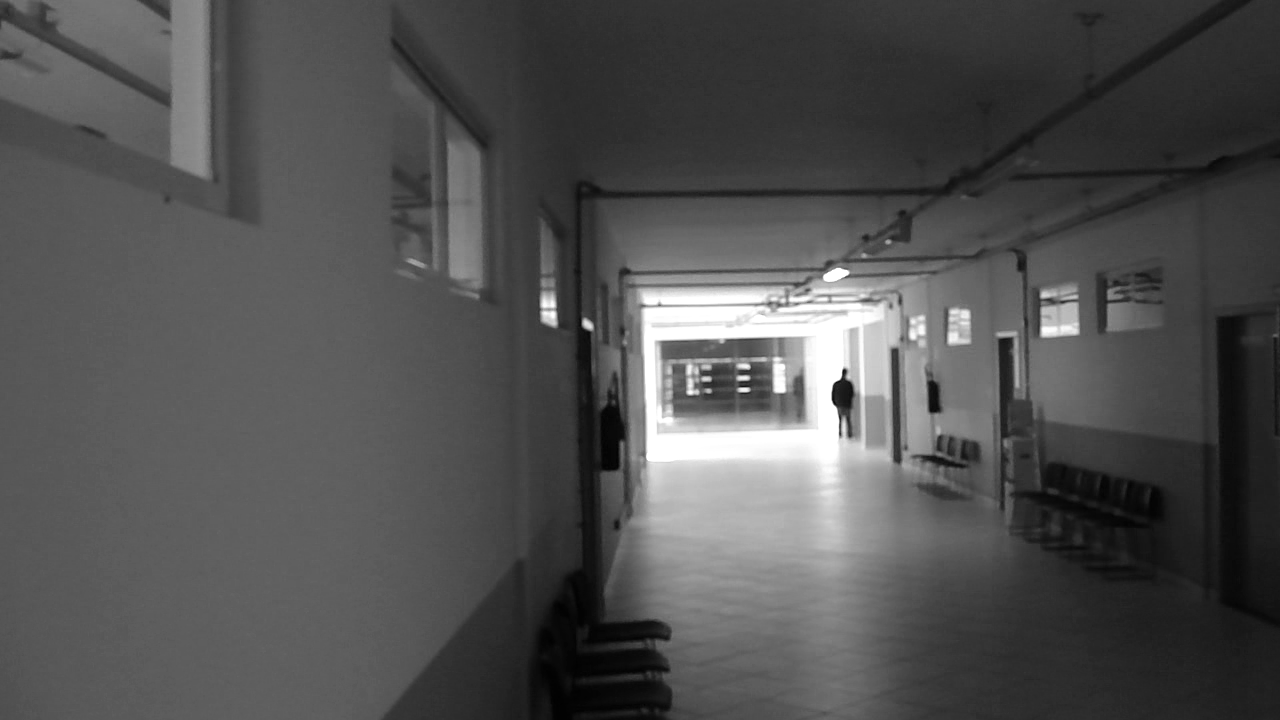

In [16]:
video_path = 'resources/video.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

buffer = prepare_frames(cap, apply_function_on_frame=lambda f: cv2.cvtColor(f, cv2.COLOR_BGR2GRAY), limit_frames=200)
play_frames(buffer)

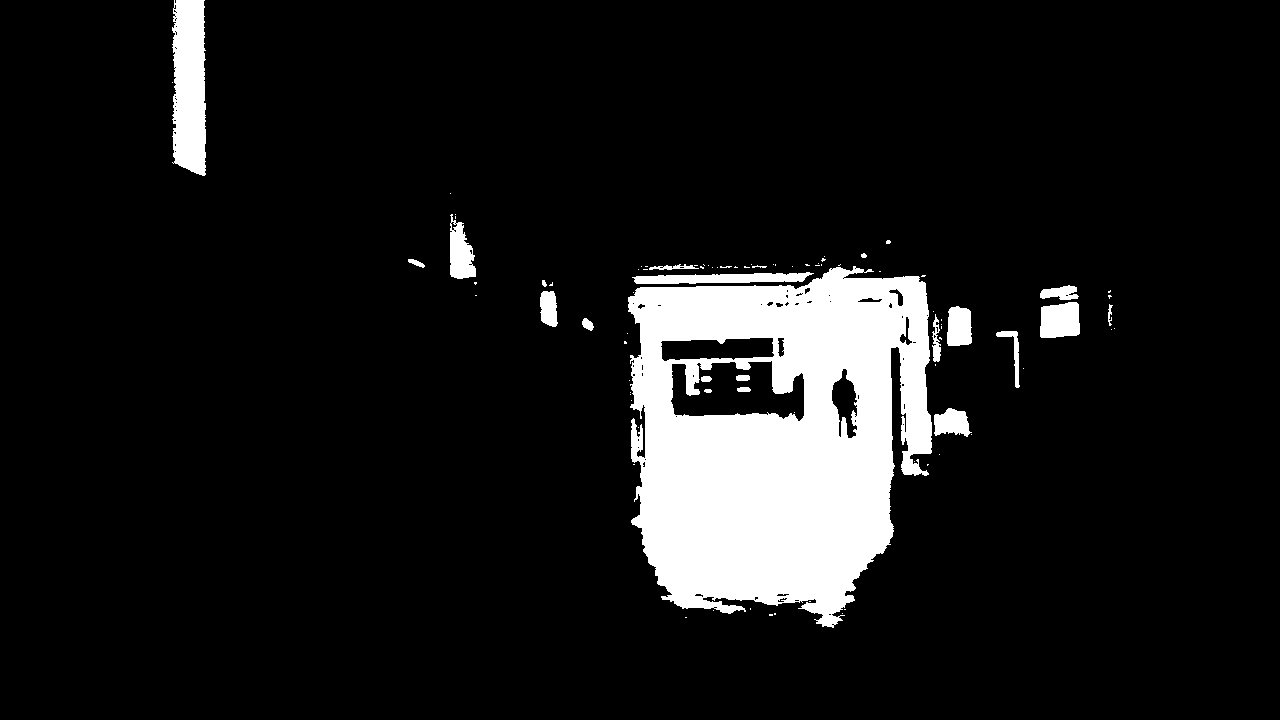

In [25]:
video_path = 'resources/video.mp4'

# Open the video file
cap = cv2.VideoCapture(video_path)

threshold = 128

def _bin_img(frame):
    return cv2.threshold(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), threshold, 255, cv2.THRESH_BINARY)[1]

buffer = prepare_frames(cap, apply_function_on_frame=_bin_img, limit_frames=200)
play_frames(buffer)

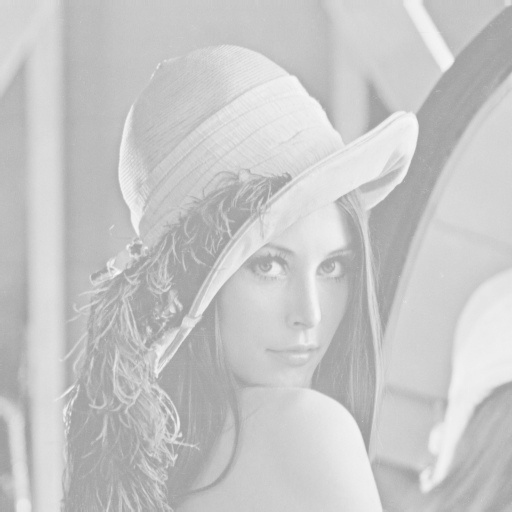

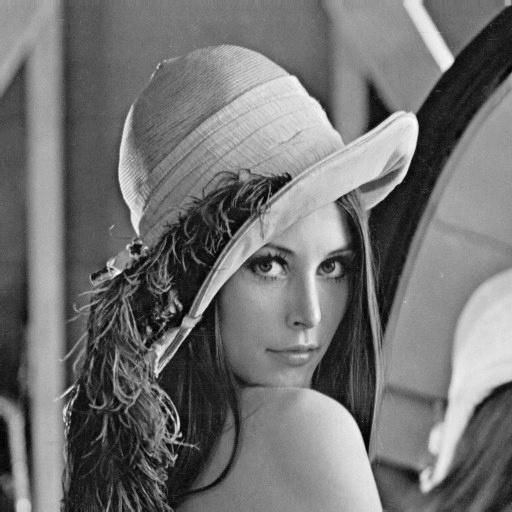

In [34]:
from copy import copy
lena = cv2.imread('resources/Lena_baixo_contraste.jpg', cv2.IMREAD_GRAYSCALE)

img_cv2 = cv2.imencode('.jpg', lena)
clear_output(wait=True)
display(Image(data=img_cv2[1].tobytes()))

max = 0
min = 255

for i in range(lena.shape[0]):
    for ii in range(lena.shape[1]):
        if int(lena[i][ii]) < min:
            min = int(lena[i][ii])
        if int(lena[i][ii]) > max:
            max = int(lena[i][ii])



gain = 255/(max-min)
bias = min

for i in range(lena.shape[0]):
    for ii in range(lena.shape[1]):
        lena[i][ii] = np.uint8((gain * (int(lena[i][ii]) - bias))//1)

img_cv2 = cv2.imencode('.jpg', lena)
display(Image(data=img_cv2[1].tobytes()))

In [82]:
from typing import List
def filtr(mat, x, y, fil: List[list]):
    if len(fil) != len(fil[0]):
        raise Exception
    m, n = len(fil), len(fil[0])
    v = 0
    for row_idx, row in enumerate(fil):
        for col_idx, gain in enumerate(row):
            i = x + col_idx - m//2
            ii = y + row_idx - n//2

            v += gain * int(mat[i][ii])
    if  v > 255:
        v = 255
    elif v < 0:
        v = 0
    return np.uint8(int(v))

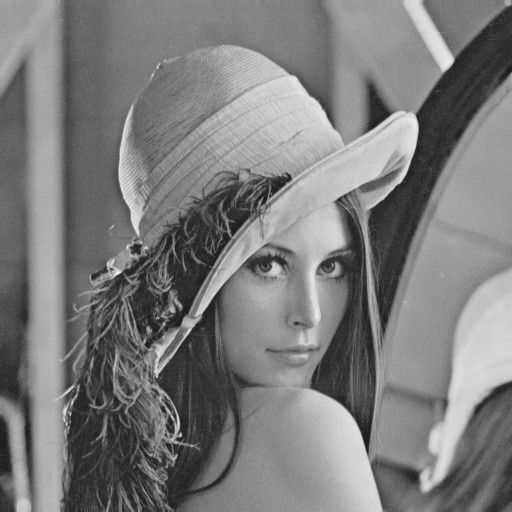

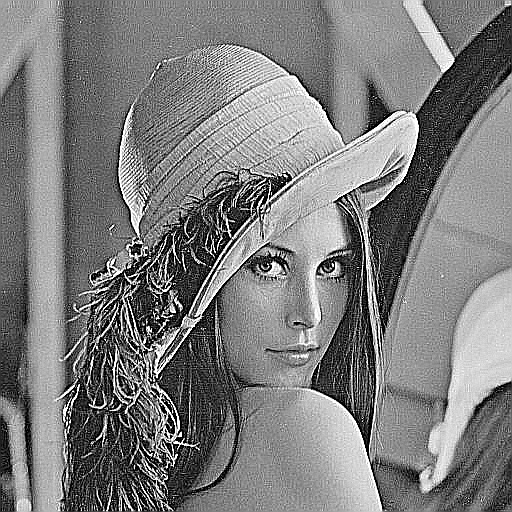

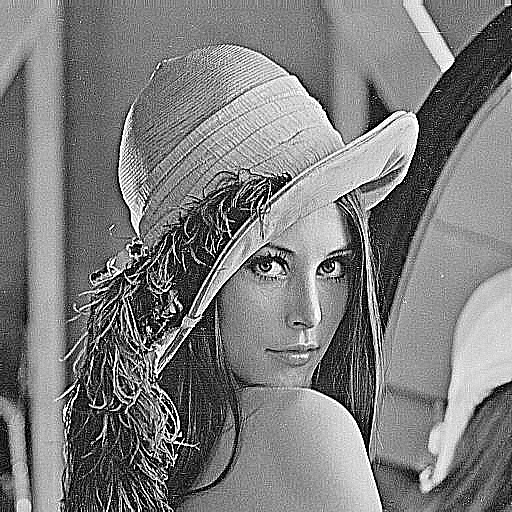

In [84]:
from copy import copy
lena = cv2.imread('resources/Lena.jpg', cv2.IMREAD_GRAYSCALE)
lena_brd = cv2.imread('resources/Lena.jpg', cv2.IMREAD_GRAYSCALE)


img_cv2 = cv2.imencode('.jpg', lena)
clear_output(wait=True)
display(Image(data=img_cv2[1].tobytes()))

fil = [
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
]

for i in range(1, lena.shape[0]-1):
    for ii in range(1, lena.shape[1]-1):
        lena_brd[i][ii] = filtr(lena, i, ii, fil)


img_cv2 = cv2.imencode('.jpg', lena_brd)
display(Image(data=img_cv2[1].tobytes()))


kernel = np.array(fil)
lena_brd_2 = cv2.filter2D(lena, -1, kernel)

img_cv2 = cv2.imencode('.jpg', lena_brd_2)
display(Image(data=img_cv2[1].tobytes()))

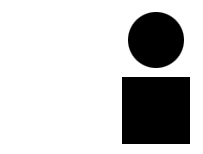

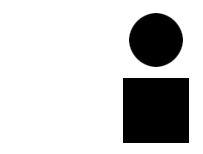

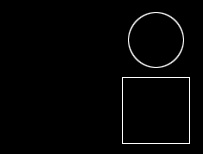

In [91]:
mat = cv2.imread('resources/imagem_figuras_geometricas_1.bmp', cv2.IMREAD_GRAYSCALE)

struc_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mat_plus = cv2.dilate(mat, struc_elem)

mat_border = mat_plus - mat

mats = [mat, mat_plus, mat_border]

clear_output(wait=True)
for m in mats:
    img_cv2 = cv2.imencode('.jpg', m)
    display(Image(data=img_cv2[1].tobytes()))


In [96]:

def display_mat(m):
    img_cv2 = cv2.imencode('.jpg', m)
    display(Image(data=img_cv2[1].tobytes()))


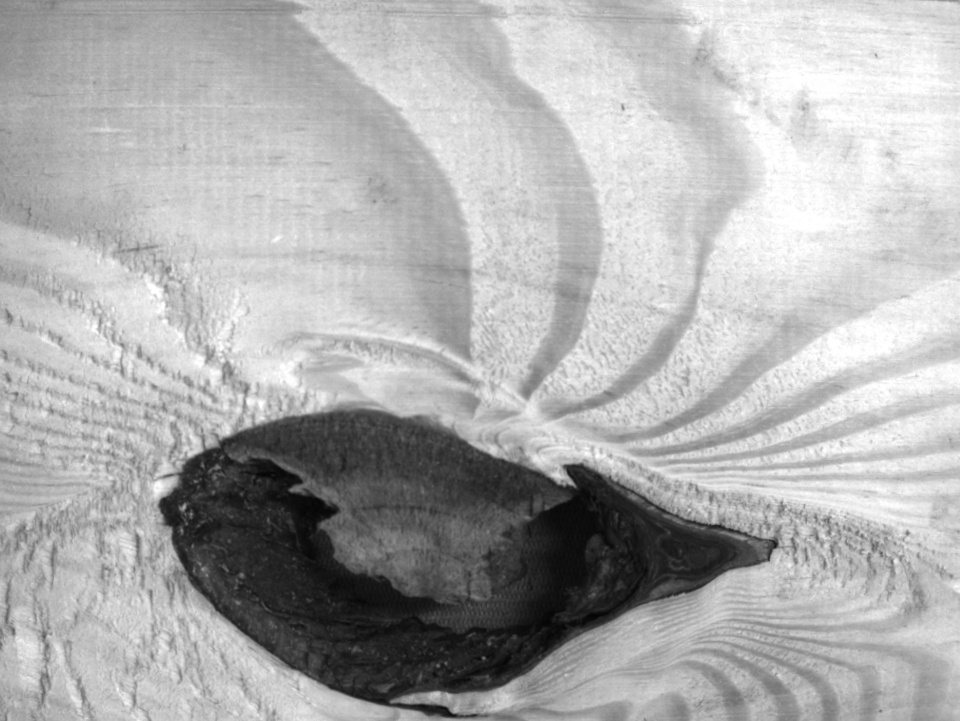

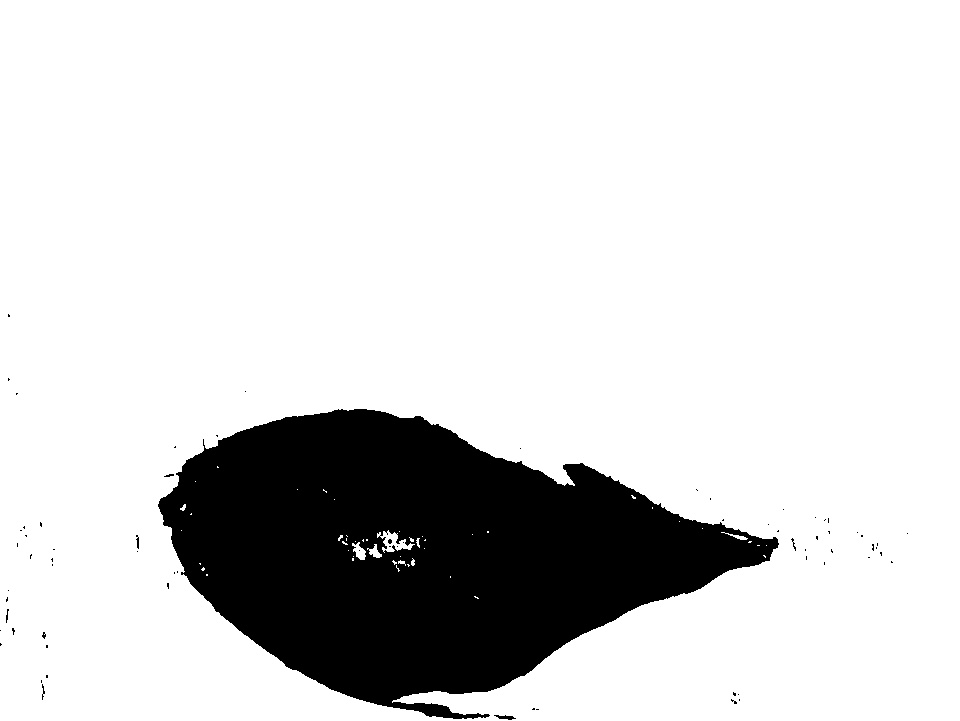

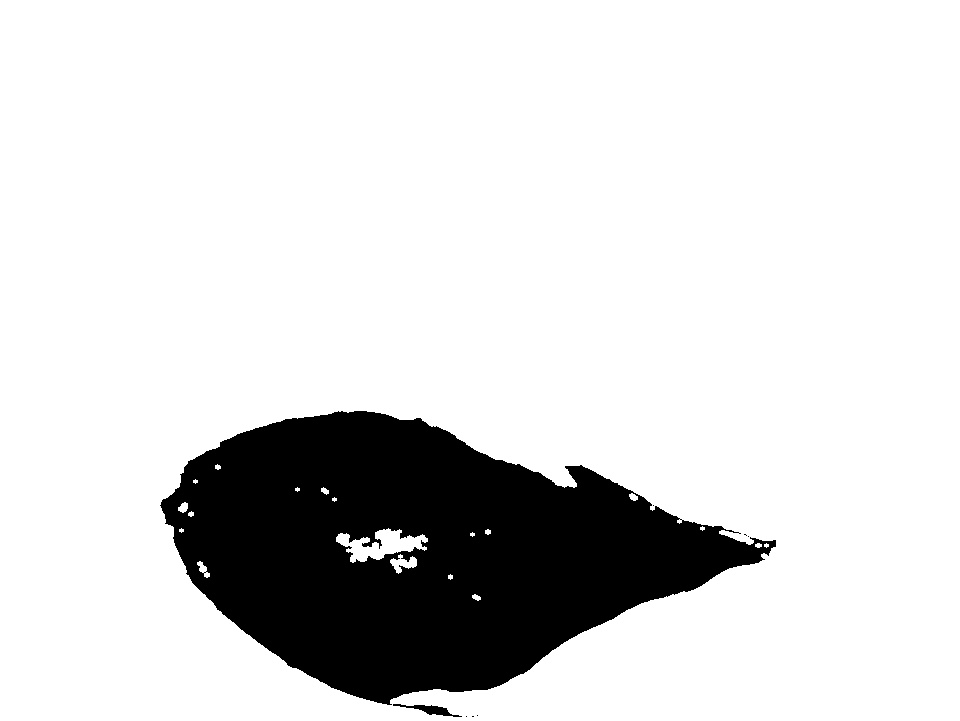

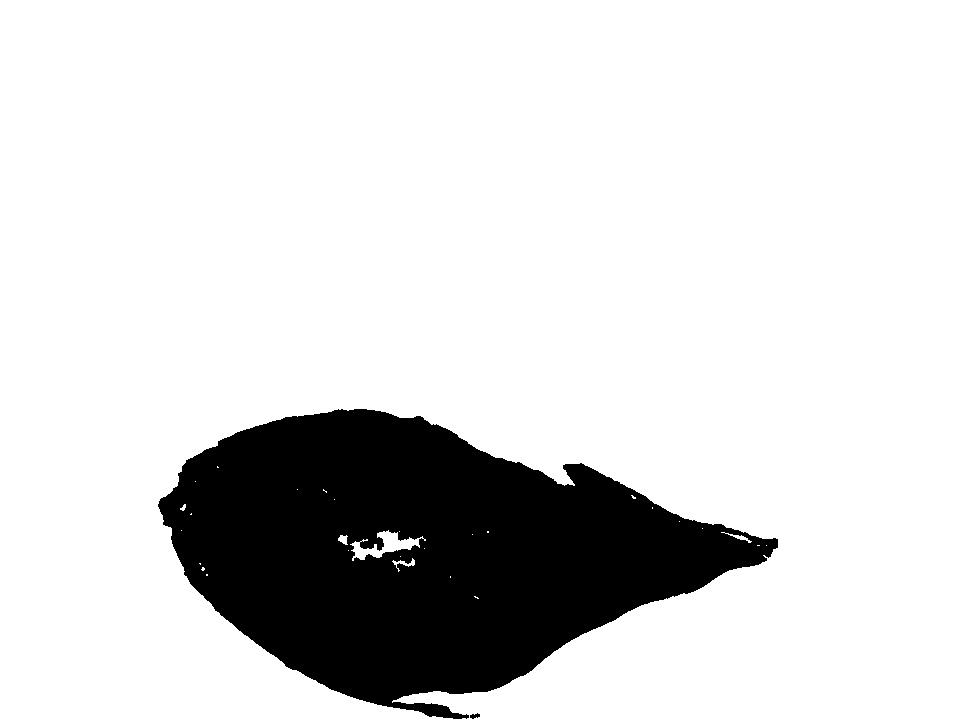

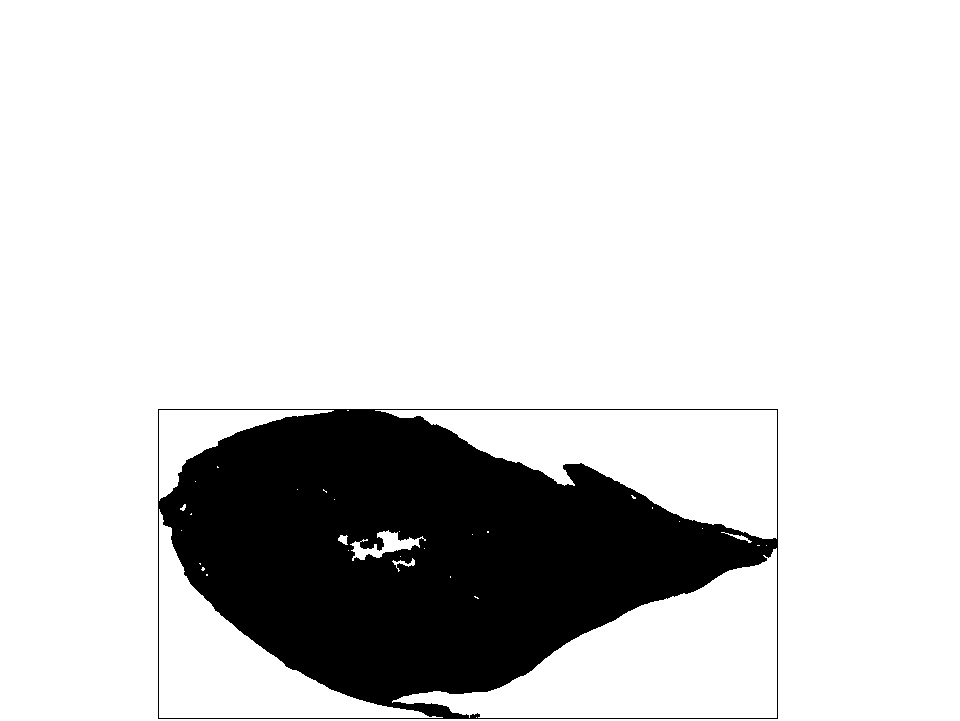

In [111]:
mat = cv2.imread('resources/madeira.jpg', cv2.IMREAD_GRAYSCALE)
display_mat(mat)

_, mat = cv2.threshold(mat, 115, 255, cv2.THRESH_BINARY)
display_mat(mat)

elem_siz = 5
struc_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (elem_siz, elem_siz))
mat = cv2.dilate(mat, struc_elem)
display_mat(mat)

mat = cv2.erode(mat, struc_elem)
display_mat(mat)

xl, xr, yu, yd = mat.shape[0],0,mat.shape[1],0
for y in range(mat.shape[0]):
    for x in range(mat.shape[1]):
        if int(mat[y][x]) == 0:
            xl = x if xl > x else xl
            xr = x if xr < x else xr
            yu = y if yu > y else yu
            yd = y if yd < y else yd

mat = cv2.rectangle(mat, (xl, yu), (xr, yd), 0)
display_mat(mat)

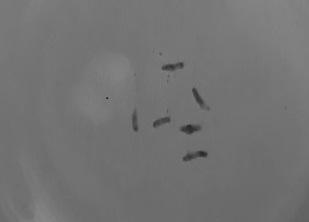

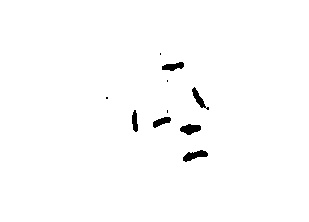

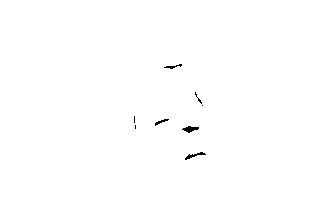

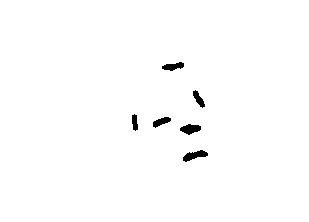

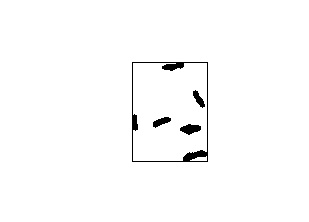

In [133]:
mat = cv2.imread('resources/artemias.jpg', cv2.IMREAD_GRAYSCALE)
display_mat(mat)

_, mat = cv2.threshold(mat, 95, 255, cv2.THRESH_BINARY)
display_mat(mat)

elem_siz = 5
struc_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (elem_siz, elem_siz))
mat = cv2.dilate(mat, struc_elem)
display_mat(mat)

mat = cv2.erode(mat, struc_elem)
display_mat(mat)

xl, xr, yu, yd = mat.shape[0],0,mat.shape[1],0
for y in range(mat.shape[0]):
    for x in range(mat.shape[1]):
        if int(mat[y][x]) == 0:
            xl = x if xl > x else xl
            xr = x if xr < x else xr
            yu = y if yu > y else yu
            yd = y if yd < y else yd

mat = cv2.rectangle(mat, (xl, yu), (xr, yd), 0)
display_mat(mat)

In [134]:
%pip install opencv-python-headless ipywidgets


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.
     --------------------------------------- 38.0/38.0 MB 29.7 MB/s eta 0:00:00




[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [137]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets

# Função de callback para lidar com eventos do mouse
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        update_image_coords(x, y)

# Função para atualizar a exibição da imagem e as coordenadas
def update_image_coords(x, y):
    color = img[y, x]
    color_hex = "#{:02x}{:02x}{:02x}".format(color[2], color[1], color[0])
    color_widget.value = f'Cor: {color_hex}'
    mouse_coords.value = f'Coordenadas: x={x}, y={y}'

# Carrega a imagem
image_path = 'resources/Lena.jpg'  # Substitua pelo caminho da sua imagem
img = cv2.imread(image_path)

# Cria a janela de exibição da imagem
cv2.namedWindow('Imagem')
cv2.setMouseCallback('Imagem', mouse_callback)

# Cria o widget de texto para a cor
color_widget = widgets.HTML(value='Cor:')

# Cria o widget da coordenada do mouse
mouse_coords = widgets.Label(value='Coordenadas:')

# Exibe os widgets
display(color_widget, mouse_coords)

try:
    while True:
        cv2.imshow('Imagem', img)
        if cv2.waitKey(1) & 0xFF == 27:  # Pressione ESC para sair
            break
except KeyboardInterrupt:
    pass
finally:
    cv2.destroyAllWindows()
    clear_output()


In [150]:
import cv2
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets


class Clk:
    def __init__(self):
        self.curstate = False
        self.cur_coords = (0, 0)
        self.rec_dot_1 = (0, 0)
        self.rec_dot_2 = (0, 0)

    def update_clk(self, nw_state):
        if self.curstate != nw_state:
            self.curstate = nw_state

            clk_widget.value = f'Clique: {self.curstate}'

            if self.curstate:
                self.rec_dot_1 = self.cur_coords
                rec_dot1_widget.value = f'rec_dot1: {clk.rec_dot_1}'
            else:
                self.rec_dot_2 = self.cur_coords
                rec_dot2_widget.value = f'rec_dot2: {clk.rec_dot_2}'

clk = Clk()

# Função de callback para lidar com eventos do mouse
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        update_image_coords(x, y)
    elif event == cv2.EVENT_LBUTTONDOWN:
        clk.update_clk(True)
    elif event == cv2.EVENT_LBUTTONUP:
        clk.update_clk(False)

# Função para atualizar a exibição da imagem e as coordenadas
def update_image_coords(x, y):
    color = img[y, x]
    color_hex = "#{:02x}{:02x}{:02x}".format(color[2], color[1], color[0])
    color_widget.value = f'Cor: {color_hex}'
    mouse_coords.value = f'Coordenadas: x={x}, y={y}'
    clk.cur_coords = (x, y)
    if clk.curstate:
        colr = np.array([0, 0, 255])
        r = 3
        for dy in range(y-r, y+1+r):
            for dx in range(x-r, x+1+r):
                img[dy, dx] = np.array([0, 0, 255])


# Carrega a imagem
image_path = 'resources/Lena.jpg'  # Substitua pelo caminho da sua imagem
img = cv2.imread(image_path)

# Cria a janela de exibição da imagem
cv2.namedWindow('Imagem')
cv2.setMouseCallback('Imagem', mouse_callback)

# Cria o widget de texto para a cor
color_widget = widgets.HTML(value='Cor:')

# Cria o widget da coordenada do mouse
mouse_coords = widgets.Label(value='Coordenadas:')


clk_widget = widgets.Label(value=f'Clique: {clk.curstate}')

rec_dot1_widget = widgets.Label(value=f'rec_dot1: {clk.rec_dot_1}')
rec_dot2_widget = widgets.Label(value=f'rec_dot2: {clk.rec_dot_2}')

# Exibe os widgets
display(color_widget, mouse_coords, clk_widget, rec_dot1_widget, rec_dot2_widget)

try:
    while True:
        cv2.imshow('Imagem', img)
        if cv2.waitKey(1) & 0xFF == 27:  # Pressione ESC para sair
            break
except KeyboardInterrupt:
    pass
finally:
    cv2.destroyAllWindows()
    clear_output()


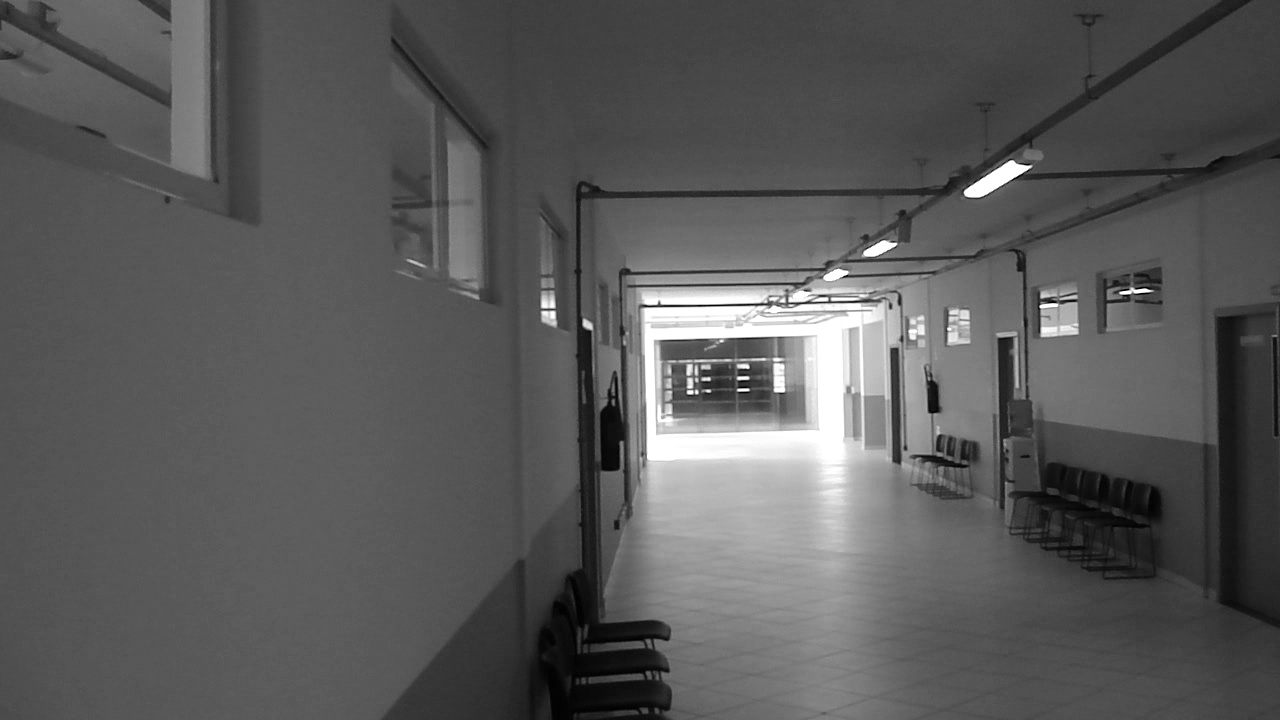

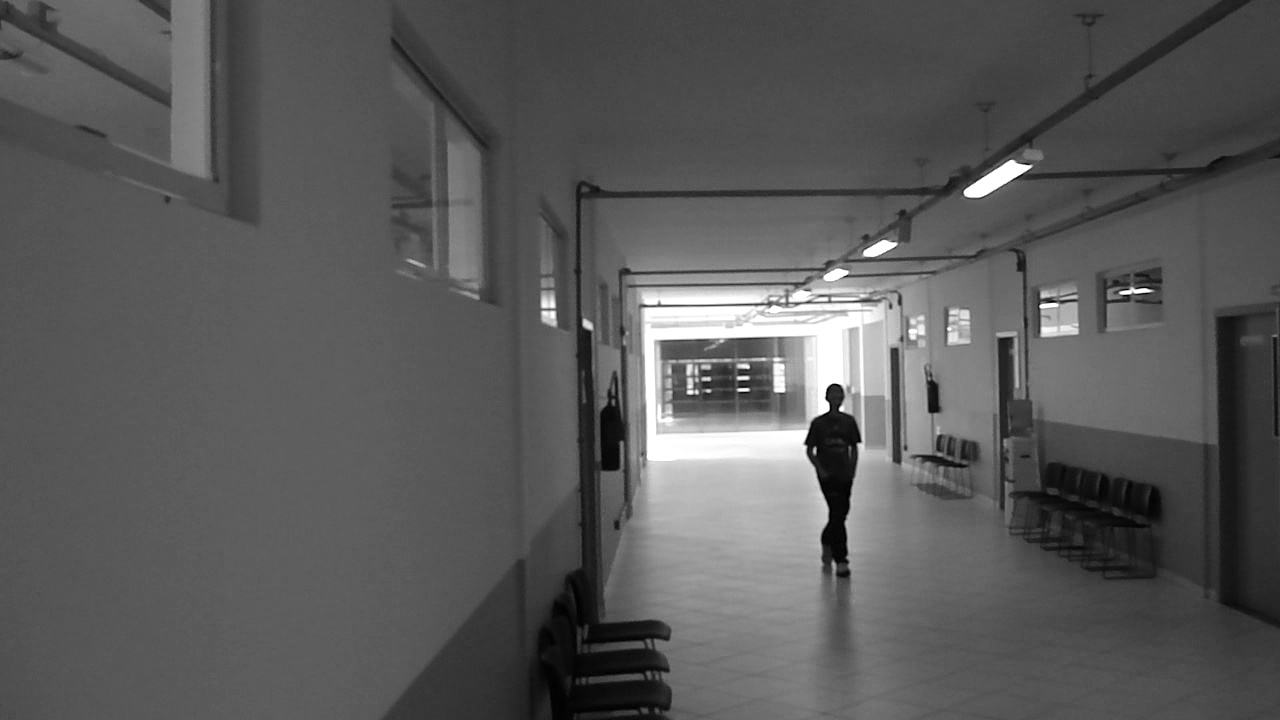

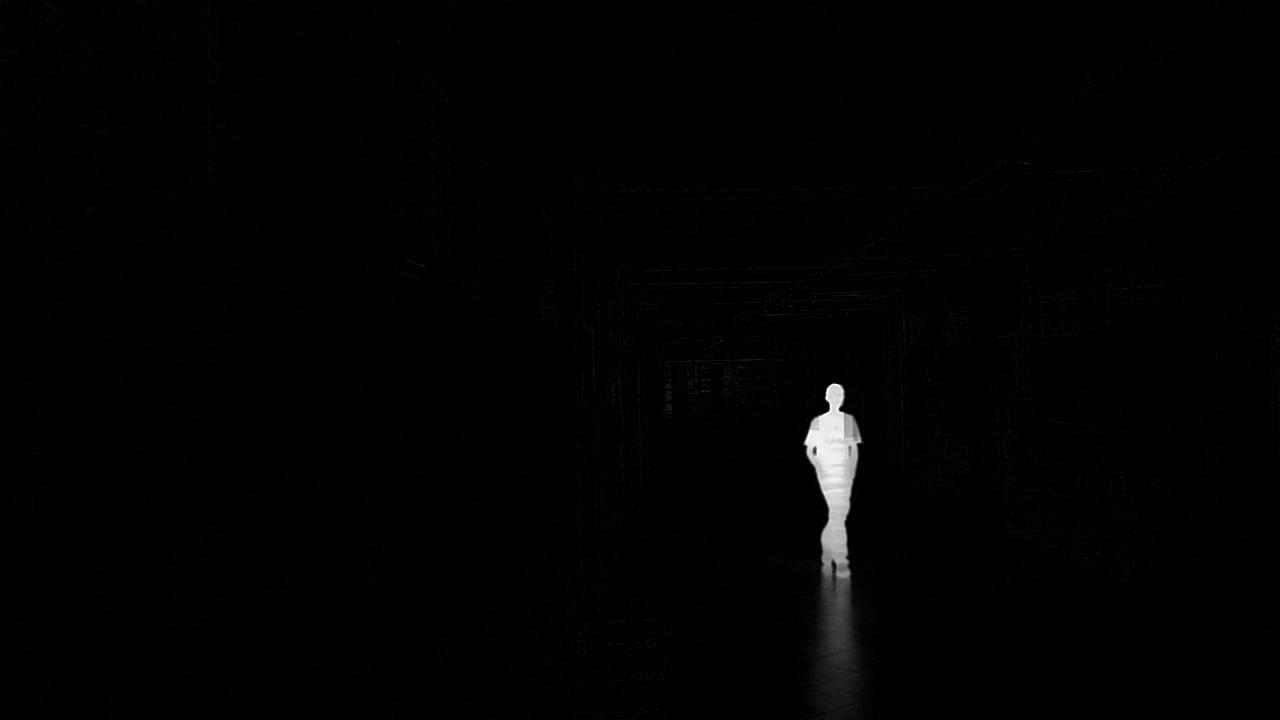

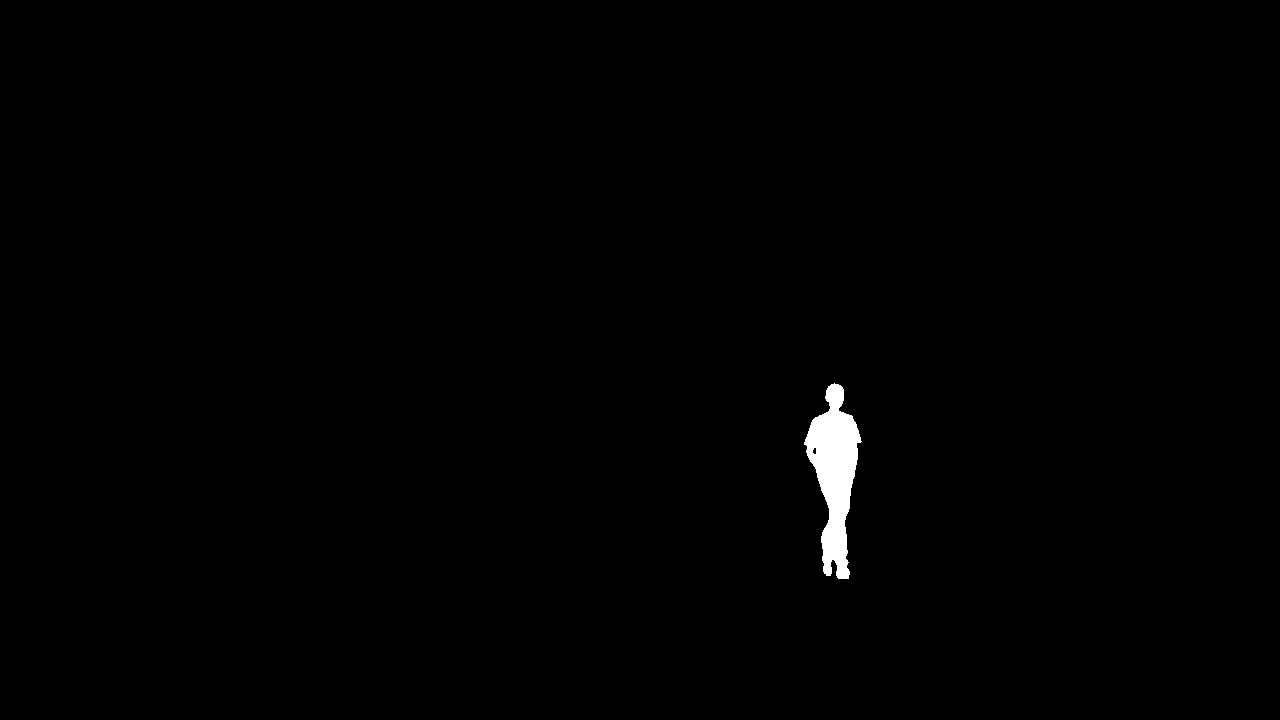

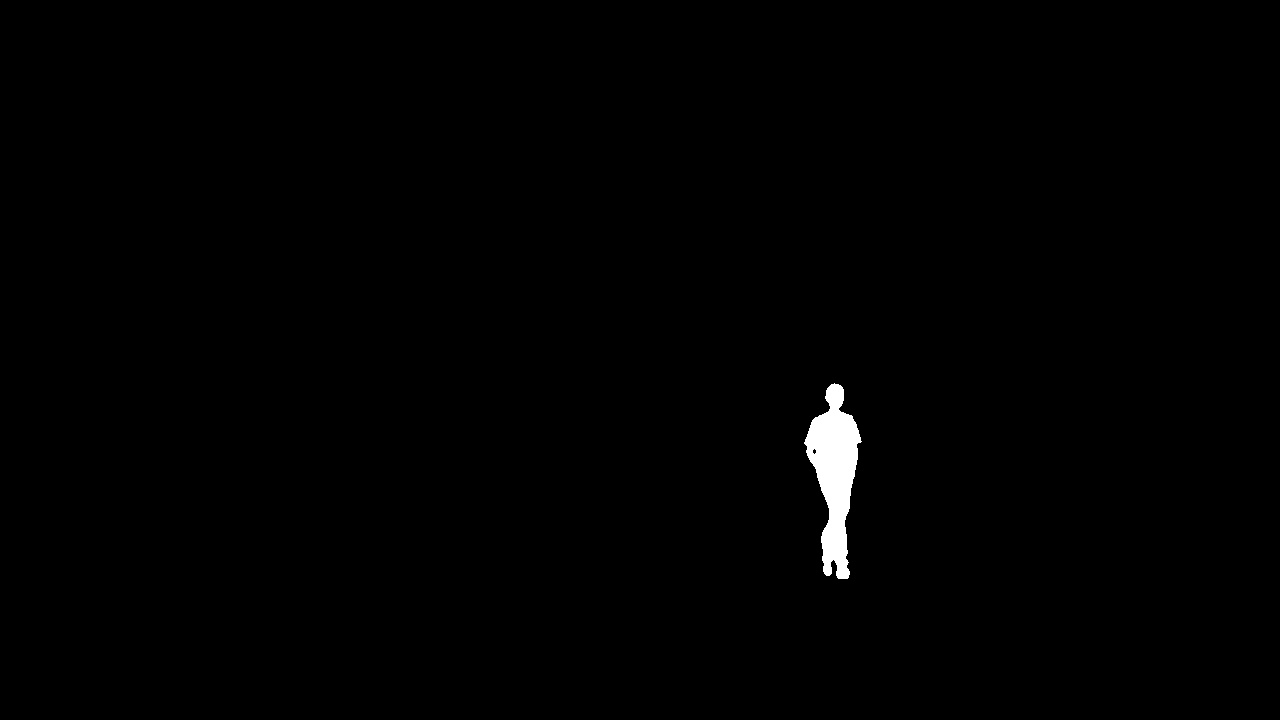

In [155]:
corredor = cv2.imread('resources/corredor.bmp', cv2.IMREAD_GRAYSCALE)
corredorobjeto = cv2.imread('resources/corredorobjeto.bmp', cv2.IMREAD_GRAYSCALE)

mat = np.clip(np.subtract(corredor.astype(int), corredorobjeto.astype(int)), 0, 255).astype(np.uint8)

_, mat_bin = cv2.threshold(mat, 90, 255, cv2.THRESH_BINARY)

elem_siz = 3
struc_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (elem_siz, elem_siz))

mat_edit = cv2.dilate(mat_bin, struc_elem)
mat_edit = cv2.erode(mat_edit, struc_elem)
mat_edit = cv2.erode(mat_edit, struc_elem)
mat_edit = cv2.dilate(mat_edit, struc_elem)

imgs = [corredor, corredorobjeto, mat, mat_bin, mat_edit]

for img in imgs:
    display_mat(img)